In [14]:
import numpy as np
import pandas as pd
import networkx as nx
import shapefile as shp

import matplotlib.style
matplotlib.style.use('classic')
from matplotlib import pyplot as plt
from scipy.integrate import ode
import time

In [2]:
K = np.loadtxt( 'params_COL/K_Colombia_pu.txt' )
P = np.loadtxt( 'params_COL/P_Colombia_pu.txt' )
positions = np.loadtxt( 'params_COL/Node_Location.txt' )

In [33]:
data = pd.read_excel('params_COL/ESTACIONES-EN-COLOMBIA (1).xlsx')

In [8]:
P[67] = 2.0

In [16]:
tobe_consumed = np.sum(P[P>0])/np.sum(P<=0)

In [18]:
P[P<=0] = -tobe_consumed

In [5]:
np.sum(P)

4.218847493575595e-15

In [34]:
np.sum(data['TIPO ESTACION'] == 'H') + np.sum(data['TIPO ESTACION'] == 'T')

28

In [41]:
np.savetxt('params_COL/P_Colombia_pu.txt', P)

In [35]:
color_nodes = np.array( ['gold' for i in range(len(P))], dtype=object )

In [36]:
color_nodes[data['TIPO ESTACION'] == 'H'] = 'deepskyblue'
color_nodes[data['TIPO ESTACION'] == 'T'] = 'crimson'

In [37]:
legend_nodes = np.array( ['Consumer' for i in range(len(P))], dtype=object )
legend_nodes[data['TIPO ESTACION'] == 'H'] = 'Hydroelectric power station'
legend_nodes[data['TIPO ESTACION'] == 'T'] = 'Thermal power station'

In [38]:
G = nx.from_numpy_matrix(K)

In [39]:
sf = shp.Reader("params_COL/COL_adm/COL_adm1.shp")

<IPython.core.display.Javascript object>


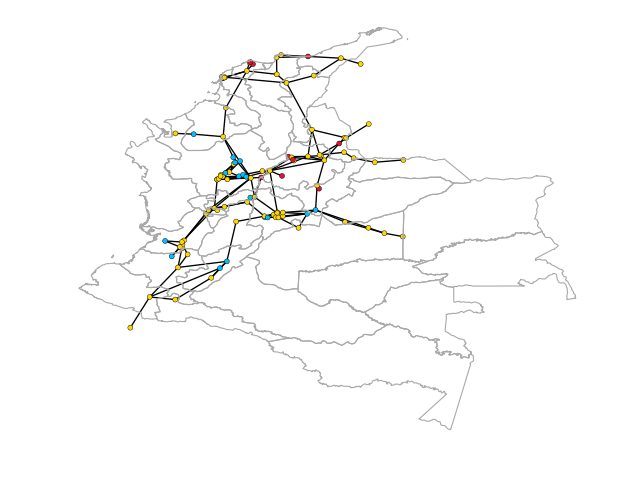

/home/yggdrasil/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [40]:
plt.figure()
for shape in sf.shapeRecords():
    for i in range(len(shape.shape.parts)):
        i_start = shape.shape.parts[i]
        if i==len(shape.shape.parts)-1:
            i_end = len(shape.shape.points)
        else:
            i_end = shape.shape.parts[i+1]
        x = [i[0] for i in shape.shape.points[i_start:i_end]]
        y = [i[1] for i in shape.shape.points[i_start:i_end]]
        plt.plot(x,y, color = 'darkgrey')

nx.draw( G, pos = positions, node_size = 20, node_color = color_nodes, \
        linewidths = 0.4, width = 1.2)#, labels = label_node, font_size = 4 )
#plt.axis('on')
plt.xlim([-80, -66])
plt.ylim([-5, 13])
plt.tight_layout()
plt.savefig('Images_2/colombian_graph.pdf')
plt.show()

In [48]:
label_node = dict()
for keyv in np.arange(0, 102, 1):
    label_node[keyv] = keyv

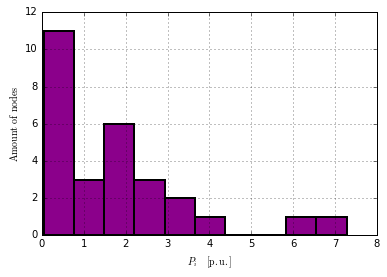

In [49]:
P_gens = P[P>0]
plt.figure()
plt.hist(P_gens, bins = 10, color = 'darkmagenta', linewidth = 2, alpha = 1)
plt.grid()
plt.xlabel(r'$P_i$'  + '   ' + r'$\rm{[p.u.]}$')
plt.ylabel(r'$\rm{Amount}$' + ' ' + r'$\rm{of}$' + ' ' + r'$\rm{nodes}$')
plt.savefig('Images_2/Hist_col_P.pdf')
plt.show()

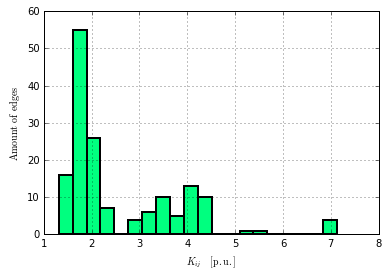

In [50]:
K2 = K[np.triu_indices(102)]

K2 = K2[K2 > 0]

plt.figure()
plt.hist(K2, bins = 20, color = 'springgreen', linewidth = 2, alpha = 1)
plt.grid()
plt.xlabel(r'$K_{ij}$'  + '   ' + r'$\rm{[p.u.]}$')
plt.ylabel(r'$\rm{Amount}$' + ' ' + r'$\rm{of}$' + ' ' + r'$\rm{edges}$')
plt.savefig('Images_2/Hist_col_K.pdf')
#plt.yscale('log')
plt.show()

In [51]:
K[np.triu_indices(102)].shape

(5253,)

In [52]:
np.sum(P)

4.218847493575595e-15

In [53]:
np.sum(P[P < 0] != P.min())

0

In [16]:
def kuramoto_2nd_order( t, x, P, K, alfs ):
	N = int(len( P ))
	theta = x[:N]
	dot_theta = x[N:]
	dotdot_theta = np.zeros( 2*N, np.float64 )
	dotdot_theta[0:N] = dot_theta
	dotdot_theta[N:] = P - np.multiply( alfs, dot_theta ) + np.sum(K * np.sin( np.repeat( theta.reshape(N,1).T, N, axis=0 ) - np.repeat( theta.reshape(N,1), N, axis=1 ) ), axis=1)

	return dotdot_theta


def kuramoto_run(x0, K, P, Alf, t_fin, ki, dinode, sim_indic, to_return):
	stim = time.time()
	N = len(P)
	solver = ode( kuramoto_2nd_order )
	solver.set_integrator('vode', method = 'bdf', order = 5, nsteps=3000)
	solver.set_f_params(P, K, Alf)
	solver.set_initial_value(x0, 0)

	i = 0
	states = []
	t = []
	while solver.successful() and solver.t < t_fin:
		solver.integrate(1, step=True) 
		states.append( solver.y )
		t.append(solver.t)
		i += 1

	t = np.array(t)
	states = np.array(states)
	

	phases_endpoint = ( states[-1, 0:N] + np.pi) % (2 * np.pi ) - np.pi
	vels_endpoint = states[-1, N:]



	stead_result = np.concatenate( [phases_endpoint, vels_endpoint] )


	etim = time.time()
	print('Done: ', sim_indic,' run_time: ', etim - stim)
	

	states[:, 0:N] = ( states[:, 0:N] + np.pi) % (2 * np.pi ) - np.pi

	plt.figure()
	plt.subplot(121)
	plt.plot(t, states[:,:N])
	plt.subplot(122)
	plt.plot(t, states[:,N:])
	plt.show()
	
	return stead_result


def synch_condition( K, w ):
	'''
	Returns an approximation to the critical coupling and to the steady state
	of the system, calculated from topological considerations.
	'''
	G = nx.from_numpy_matrix(K)
	L_dagger = np.linalg.pinv( nx.laplacian_matrix( G ).todense() )
	B = nx.incidence_matrix( G, oriented = True ).todense()
	theta_ss = np.matmul(L_dagger, w) 
	x0 = np.concatenate((theta_ss, 0*theta_ss), axis=1).T
	x0 = x0.flatten()
	x0 = x0.tolist()
	x0 = x0[0]
	k_crit = np.linalg.norm( np.matmul( B.T, theta_ss.T ), np.inf )

	return k_crit, x0

In [18]:
%matplotlib notebook

Done:  -1  run_time:  6.80767822265625


<IPython.core.display.Javascript object>


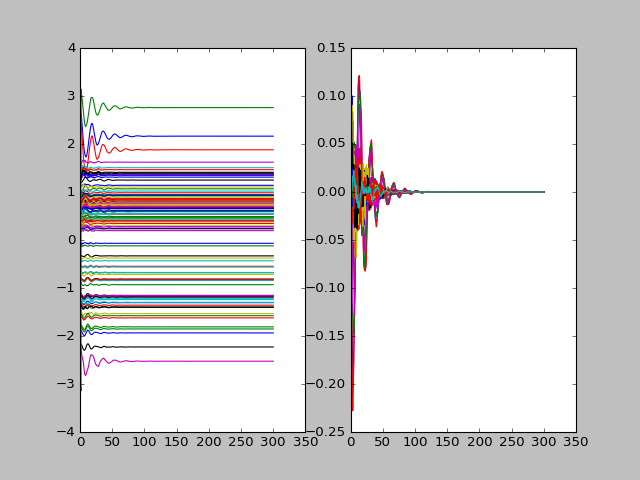

In [22]:
ci = 1.5
K_new = ci*K
kth = -1
Alf = 0.1*np.ones( P.shape )
k_crit, x0 = synch_condition( K_new, P )
y0 = kuramoto_run( x0, K_new, P, Alf, 300, ci, kth, -1, True )

In [43]:
links_load = list()

for i in range(K.shape[0]):
    for j in range(K.shape[1]):
        if ((j>i) and (K[i,j] > 0)):
            links_load.append([i, j, np.abs(np.sin( y0[j] - y0[i] ))])
            
links_load = np.array( links_load )

<IPython.core.display.Javascript object>


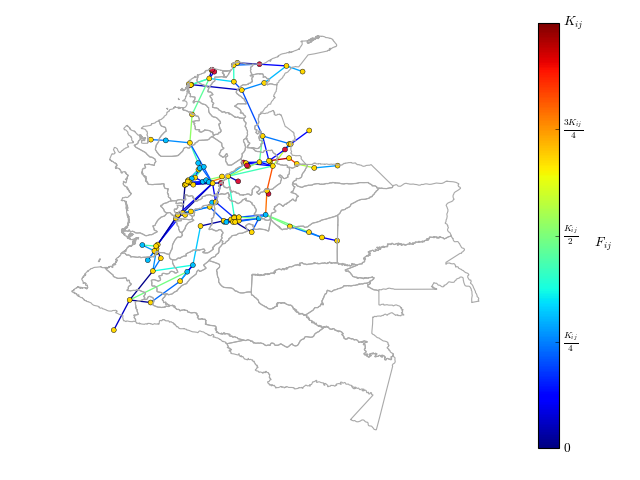

In [83]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
for shape in sf.shapeRecords():
    for i in range(len(shape.shape.parts)):
        i_start = shape.shape.parts[i]
        if i==len(shape.shape.parts)-1:
            i_end = len(shape.shape.points)
        else:
            i_end = shape.shape.parts[i+1]
        x = [i[0] for i in shape.shape.points[i_start:i_end]]
        y = [i[1] for i in shape.shape.points[i_start:i_end]]
        plt.plot(x,y, color = 'darkgrey')

da_cmap = plt.get_cmap('jet')
        
nx.draw( G, pos = positions, node_size = 20, node_color = color_nodes, \
        linewidths = 0.4, width = 1.2, edge_color = np.abs(links_load[:,2]), edge_cmap = da_cmap, \
       edge_vmin = 0.0, edge_vmax = 1.0)#, labels = label_node, font_size = 4 )

sm = plt.cm.ScalarMappable(cmap = da_cmap, norm=plt.Normalize(vmin=0.0, vmax=1.0))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('       ' + r'$F_{ij}$', rotation = 0)
cbar.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0])
cbar.set_ticklabels([r'$0$', r'$\frac{K_{ij}}{4}$', r'$\frac{K_{ij}}{2}$', r'$\frac{3K_{ij}}{4}$', r'$K_{ij}$'])
#plt.axis('on')
#cbar.ax1.set_ticklabels_position('left')
plt.xlim([-80, -66])
plt.ylim([-5, 13])
plt.tight_layout()
plt.savefig('Images_2/colombian_graph_linkload.pdf')
plt.show()